### Aprendizado de M√°quina Li√ß√£o 5: Criando Rede Neural e modelo linear

## Autor
**Nome**: Pedro Lucas Cassiano Martins<br>
**Matr√≠cula**: 190036567<br>
**Github**: [PedroLucasCM](github.com/PedroLucasCM)

## Objetivo
<p>O objetivo deste artigo 3 foi o de estudar modelos lineares e redes neurais com o fast.ai. Nesse artigo, o objetivo √© o de criar um modelo linear e uma rede neural do zero com a ajuda das bibliotecas pytorch, numpy e pandas.</p>


## Atualiza√ß√£o e Imports

In [2]:
import os
import warnings

# C√≥digo para ignorar avisos de usu√°rio
warnings.filterwarnings("ignore", category=UserWarning)

#!pip install -Uqq torch==2.0.1
#!pip install -Uqq torchdata==0.6.1

from fastai.data.transforms import RandomSplitter
from pathlib import Path
import torch
from torch import tensor
import numpy as np
import pandas as pd
import sympy
import torch.nn.functional as F
from ipywidgets import interact

In [3]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Dataset

Nesse artigo ser√° usado o dataset da competi√ß√£o [Prediction of Wild Blueberry Yield](https://www.kaggle.com/competitions/playground-series-s3e14/overview) que foi utilizado para predizer a quantidade de mirtilos colhidos baseados em alguns fatores como densidade de v√°rios tipos de abelha, dias de chuva e dias de sol, temperatura do ar, quantidade de sementes e tamanho dos 'clones' de mirtilo.

## Execu√ß√£o
* ### Limpando os dados

Primeiramente vamos colocar o path do dataset da competi√ß√£o:

In [4]:
path = Path('/kaggle/input/playground-series-s3e14')

Podemos ent√£o criar e abrir o dataset de treino para visualizar as colunas e valores com que vamos trabalhar

In [5]:
df = pd.read_csv(path/'train.csv')
df

id  clonesize  honeybee  bumbles  andrena  osmia  MaxOfUpperTRange  MinOfUpperTRange  AverageOfUpperTRange  MaxOfLowerTRange  \
0          0       25.0      0.50     0.25     0.75   0.50              69.7              42.1                  58.2              50.2   
1          1       25.0      0.50     0.25     0.50   0.50              69.7              42.1                  58.2              50.2   
2          2       12.5      0.25     0.25     0.63   0.63              86.0              52.0                  71.9              62.0   
3          3       12.5      0.25     0.25     0.63   0.50              77.4              46.8                  64.7              55.8   
4          4       25.0      0.50     0.25     0.63   0.63              77.4              46.8                  64.7              55.8   
...      ...        ...       ...      ...      ...    ...               ...               ...                   ...               ...   
15284  15284       12.5      0.25     0.25     0.38   0.50              77.4              46.8                  64.7              55.8   
15285  15285       12.5      0.25     0.25     0.25   0.50              86.0              52.0                  71.9              62.0   
15286  15286       25.0      0.50     0.25     0.38   0.75              77.4              46.8                  64.7              55.8   
15287  15287       25.0      0.50     0.25     0.63   0.63              69.7              42.1                  58.2              50.2   
15288  15288       25.0      0.50     0.25     0.63   0.50              77.4              46.8                  64.7              55.8   

       MinOfLowerTRange  AverageOfLowerTRange  RainingDays  AverageRainingDays  fruitset  fruitmass      seeds       yield  
0                  24.3                  41.2         24.0                0.39  0.425011   0.417545  32.460887  4476.81146  
1                  24.3                  41.2         24.0                0.39  0.444908   0.422051  33.858317  5548.12201  
2                  30.0                  50.8         24.0                0.39  0.552927   0.470853  38.341781  6869.77760  
3                  27.0                  45.8         24.0                0.39  0.565976   0.478137  39.467561  6880.77590  
4                  27.0                  45.8         24.0                0.39  0.579677   0.494165  40.484512  7479.93417  
...                 ...                   ...          ...                 ...       ...        ...        ...         ...  
15284              27.0                  45.8         16.0                0.26  0.556302   0.476308  40.546480  7667.83619  
15285              30.0                  50.8         34.0                0.56  0.354413   0.388145  29.467434  3680.56025  
15286              27.0                  45.8         34.0                0.56  0.422548   0.416786  32.299059  4696.44394  
15287              24.3                  41.2         24.0                0.39  0.542170   0.434133  36.674243  6772.93347  
15288              27.0                  45.8         16.0                0.26  0.492077   0.446576  35.094733  5867.99722  

[15289 rows x 18 columns]

N√£o podemos trabalhar com valores que n√£o existem, ent√£o vamos checar se a tabela possui valores **NaN** (*not a number*):

In [6]:
df.isna().sum()

id                      0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

O n√∫mero na direita √© a quantidade de valores **NaN** para cada coluna, para remov√™-los podemos tirar a moda entre os valores daquela coluna e usar o resultado para preencher o campo **NaN**. E ent√£o veremos que n√£o tem mais colunas vazias.

In [7]:
modes = df.mode().iloc[0]
modes

id                         0.000000
clonesize                 25.000000
honeybee                   0.500000
bumbles                    0.250000
andrena                    0.380000
osmia                      0.630000
MaxOfUpperTRange          86.000000
MinOfUpperTRange          52.000000
AverageOfUpperTRange      71.900000
MaxOfLowerTRange          62.000000
MinOfLowerTRange          30.000000
AverageOfLowerTRange      50.800000
RainingDays               16.000000
AverageRainingDays         0.260000
fruitset                   0.583379
fruitmass                  0.446570
seeds                     39.988734
yield                   6251.611840
Name: 0, dtype: float64

In [8]:
df.fillna(modes, inplace=True)
df.isna().sum()

id                      0
clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

Vamos checar as colunas com valores num√©ricos que s√£o todas:

In [9]:
df.describe(include=(np.number))

id     clonesize      honeybee       bumbles       andrena         osmia  MaxOfUpperTRange  MinOfUpperTRange  \
count  15289.000000  15289.000000  15289.000000  15289.000000  15289.000000  15289.000000      15289.000000      15289.000000   
mean    7644.000000     19.704690      0.389314      0.286768      0.492675      0.592355         82.169887         49.673281   
std     4413.698468      6.595211      0.361643      0.059917      0.148115      0.139489          9.146703          5.546405   
min        0.000000     10.000000      0.000000      0.000000      0.000000      0.000000         69.700000         39.000000   
25%     3822.000000     12.500000      0.250000      0.250000      0.380000      0.500000         77.400000         46.800000   
50%     7644.000000     25.000000      0.500000      0.250000      0.500000      0.630000         86.000000         52.000000   
75%    11466.000000     25.000000      0.500000      0.380000      0.630000      0.750000         86.000000         52.000000   
max    15288.000000     40.000000     18.430000      0.585000      0.750000      0.750000         94.600000         57.200000   

       AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  AverageOfLowerTRange   RainingDays  AverageRainingDays      fruitset  \
count          15289.000000      15289.000000      15289.000000          15289.000000  15289.000000        15289.000000  15289.000000   
mean              68.656256         59.229538         28.660553             48.568500     18.660865            0.324176      0.502741   
std                7.641807          6.610640          3.195367              5.390545     11.657582            0.163905      0.074390   
min               58.200000         50.200000         24.300000             41.200000      1.000000            0.060000      0.192732   
25%               64.700000         55.800000         27.000000             45.800000     16.000000            0.260000      0.458246   
50%               71.900000         62.000000         30.000000             50.800000     16.000000            0.260000      0.506600   
75%               71.900000         62.000000         30.000000             50.800000     24.000000            0.390000      0.560445   
max               79.000000         68.200000         33.000000             55.900000     34.000000            0.560000      0.652144   

          fruitmass         seeds         yield  
count  15289.000000  15289.000000  15289.000000  
mean       0.446553     36.164950   6025.193999  
std        0.037035      4.031087   1337.056850  
min        0.311921     22.079199   1945.530610  
25%        0.419216     33.232449   5128.163510  
50%        0.446570     36.040675   6117.475900  
75%        0.474134     39.158238   7019.694380  
max        0.535660     46.585105   8969.401840

Temos uma coluna `yield` que representa a quantidade de blueberries na colheita de cada `id`. Podemos ver o histograma dessa coluna a seguir:

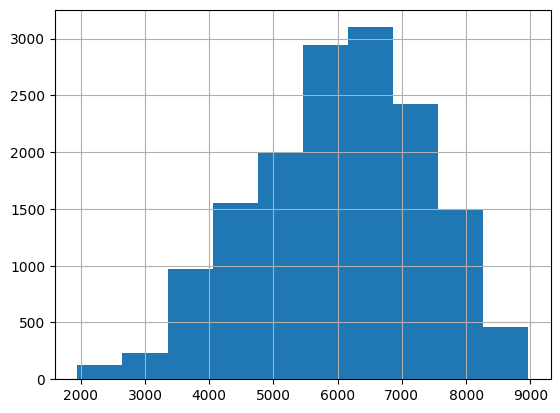

In [10]:
df['yield'].hist();

A grande maioria dos valores est√° entre 3000 e 9000. Usaremos ent√£o uma fun√ß√£o logar√≠timica para diminuir essa quantidade e n√£o ter problema na hora do c√°lculo com o coeficiente:

In [11]:
df['LogYield'] = np.log(df['yield']+1)

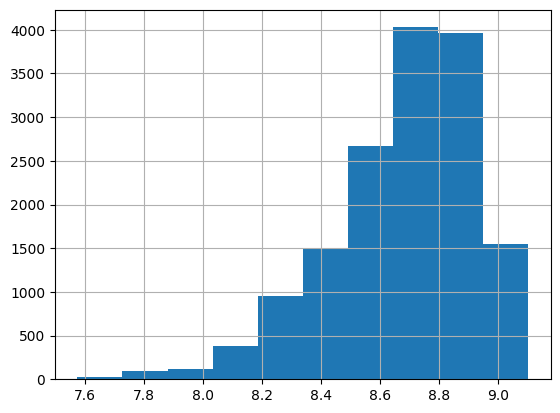

In [12]:
df['LogYield'].hist();

Podemos ver que diminuiu bastante para 7.6 e 9.

In [13]:
df.columns

Index(['id', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass',
       'seeds', 'yield', 'LogYield'],
      dtype='object')

Podemos criar nossas vari√°veis independentes (usadas na predi√ß√£o) e dependentes (que ser√° inferido). Elas devem ser tensores do PyTorch.

In [14]:
t_dep = tensor(df['yield'])
indep_columns = ['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass',
       'seeds']

##torch.set_printoptions(threshold=np.inf)

t_indep = tensor(df[indep_columns].values, dtype=torch.float)
t_indep

tensor([[25.0000,  0.5000,  0.2500,  0.7500,  0.5000, 69.7000, 42.1000,  ..., 24.3000, 41.2000, 24.0000,  0.3900,  0.4250,  0.4175,
         32.4609],
        [25.0000,  0.5000,  0.2500,  0.5000,  0.5000, 69.7000, 42.1000,  ..., 24.3000, 41.2000, 24.0000,  0.3900,  0.4449,  0.4221,
         33.8583],
        [12.5000,  0.2500,  0.2500,  0.6300,  0.6300, 86.0000, 52.0000,  ..., 30.0000, 50.8000, 24.0000,  0.3900,  0.5529,  0.4709,
         38.3418],
        [12.5000,  0.2500,  0.2500,  0.6300,  0.5000, 77.4000, 46.8000,  ..., 27.0000, 45.8000, 24.0000,  0.3900,  0.5660,  0.4781,
         39.4676],
        [25.0000,  0.5000,  0.2500,  0.6300,  0.6300, 77.4000, 46.8000,  ..., 27.0000, 45.8000, 24.0000,  0.3900,  0.5797,  0.4942,
         40.4845],
        [25.0000,  0.5000,  0.2500,  0.6300,  0.7500, 94.6000, 57.2000,  ..., 33.0000, 55.9000, 34.0000,  0.5600,  0.5652,  0.4843,
         40.5550],
        [12.5000,  0.2500,  0.3800,  0.5000,  0.6300, 86.0000, 52.0000,  ..., 30.0000, 50.8000

In [15]:
t_indep.shape

torch.Size([15289, 16])

In [16]:
indep_columns

['clonesize',
 'honeybee',
 'bumbles',
 'andrena',
 'osmia',
 'MaxOfUpperTRange',
 'MinOfUpperTRange',
 'AverageOfUpperTRange',
 'MaxOfLowerTRange',
 'MinOfLowerTRange',
 'AverageOfLowerTRange',
 'RainingDays',
 'AverageRainingDays',
 'fruitset',
 'fruitmass',
 'seeds']

* ### Criando Modelo Linear

Com a matriz de vari√°veis independentes e o vetor de vari√°vel dependente podemos calcular as predi√ß√µes e a perda. Nessa se√ß√£o vamos fazer manualmente um passo desse c√°lculo para cada linha.

O primeiro modelo ser√° linear, e precisa de um coeficiente para cada coluna, ent√£o vamos pegar valores aleat√≥rios entre `(-0.5, 0.5)`.

In [17]:
n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.5

In [18]:
coeffs.shape

torch.Size([16])

In [19]:
t_indep*coeffs

tensor([[     2.3037,      0.1576,     -0.1239,     -0.2976,      0.1156,    -16.3589,     13.6767,  ...,      9.3864,      5.3137,
             -5.9261,     -0.0461,     -0.0081,      0.1381,    -15.9420],
        [     2.3037,      0.1576,     -0.1239,     -0.1984,      0.1156,    -16.3589,     13.6767,  ...,      9.3864,      5.3137,
             -5.9261,     -0.0461,     -0.0085,      0.1396,    -16.6283],
        [     1.1518,      0.0788,     -0.1239,     -0.2500,      0.1456,    -20.1846,     16.8929,  ...,     11.5881,      6.5519,
             -5.9261,     -0.0461,     -0.0105,      0.1557,    -18.8302],
        [     1.1518,      0.0788,     -0.1239,     -0.2500,      0.1156,    -18.1662,     15.2036,  ...,     10.4293,      5.9070,
             -5.9261,     -0.0461,     -0.0108,      0.1581,    -19.3831],
        [     2.3037,      0.1576,     -0.1239,     -0.2500,      0.1456,    -18.1662,     15.2036,  ...,     10.4293,      5.9070,
             -5.9261,     -0.0461,     -

Podemos ver que a coluna da Idade possui uma m√©dia muito maior do que as outras, o que pode afetar nosso modelo, ent√£o vamos restringir as colunas a valores de 0 a 1.

In [20]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals
t_indep*coeffs

tensor([[ 0.0576,  0.0086, -0.2117, -0.3968,  0.1541, -0.1729,  0.2391,  ...,  0.2844,  0.0951, -0.1743, -0.0824, -0.0124,  0.2578,
         -0.3422],
        [ 0.0576,  0.0086, -0.2117, -0.2646,  0.1541, -0.1729,  0.2391,  ...,  0.2844,  0.0951, -0.1743, -0.0824, -0.0130,  0.2606,
         -0.3569],
        [ 0.0288,  0.0043, -0.2117, -0.3334,  0.1941, -0.2134,  0.2953,  ...,  0.3512,  0.1172, -0.1743, -0.0824, -0.0161,  0.2907,
         -0.4042],
        [ 0.0288,  0.0043, -0.2117, -0.3334,  0.1541, -0.1920,  0.2658,  ...,  0.3160,  0.1057, -0.1743, -0.0824, -0.0165,  0.2952,
         -0.4161],
        [ 0.0576,  0.0086, -0.2117, -0.3334,  0.1941, -0.1920,  0.2658,  ...,  0.3160,  0.1057, -0.1743, -0.0824, -0.0169,  0.3051,
         -0.4268],
        [ 0.0576,  0.0086, -0.2117, -0.3334,  0.2311, -0.2347,  0.3249,  ...,  0.3863,  0.1290, -0.2469, -0.1183, -0.0165,  0.2991,
         -0.4275],
        [ 0.0288,  0.0043, -0.3219, -0.2646,  0.1941, -0.2134,  0.2953,  ...,  0.3512,  0.1172

Podemos ent√£o somar as linhas do produto para criar infer√™ncias:

In [21]:
preds = (t_indep*coeffs).sum(axis=1)
preds[:16]

tensor([-0.2121, -0.0924, -0.0501, -0.1631, -0.0912, -0.0383, -0.0777,  0.1454,  0.2135, -0.0077,  0.0093, -0.0345, -0.1364,  0.0333,
        -0.1055,  0.0146])

In [22]:
t_dep.shape

torch.Size([15289])

In [23]:
vals,indices = t_dep.max(dim=0)
t_dep = t_dep/vals
t_dep

tensor([0.4991, 0.6186, 0.7659, 0.7671, 0.8339, 0.8102, 0.6399,  ..., 0.5622, 0.6128, 0.8549, 0.4103, 0.5236, 0.7551, 0.6542],
       dtype=torch.float64)

Para utilizar o m√©todo do gradiente devemos ter uma fun√ß√£o de perda, ent√£o vamos criar uma que representa o erro m√©dio das linhas:

In [24]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.6402, dtype=torch.float64)

Podemos ent√£o colocar esses c√°lculos dentro de fun√ß√µes para usar mais adiante.

In [25]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

* ### M√©todo do gradiente

Vamos fazer uma √∫nica √©poca do m√©todo do gradiente. Para calcular os gradientes, devemos usar `requires_grad_()` nos coeficientes.

In [26]:
coeffs.requires_grad_()
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.6402, dtype=torch.float64, grad_fn=<MeanBackward0>)

Vemos que a loss est√° em 1.46, a mesma de antes pois n√£o mudamos nada na loss.
Para calcular os gradientes, usamos a fun√ß√£o `backward()`:

In [27]:
loss.backward()
coeffs.grad

tensor([-0.4905, -0.0206, -0.4890, -0.6557, -0.7878, -0.8655, -0.8653, -0.8659, -0.8653, -0.8654, -0.8657, -0.5483, -0.5782, -0.7690,
        -0.8313, -0.7742])

A cada chamada do `backward()` os gradientes s√£o somados ao que estiver no atributo `grad`:

In [28]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

tensor([-0.9811, -0.0412, -0.9780, -1.3113, -1.5756, -1.7309, -1.7305, -1.7318, -1.7306, -1.7307, -1.7314, -1.0966, -1.1563, -1.5381,
        -1.6625, -1.5483])

  Vamos realizar um passo e checar se a perda diminui:

In [29]:
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(1.0737, dtype=torch.float64)


Vemos que o loss diminuiu agora, ficando em 1.117.

Obs: No PyTorch, m√©todos terminados em `_` realizam a opera√ß√£o *in-place*.

## Treinando o modelo

Primeiro vamos separar um conjunto de dados para treino e outro para valida√ß√£o:

In [30]:
trn_split, val_split = RandomSplitter(valid_pct=0.2, seed=42)(df)

A fun√ß√£o `RandomSplitter` vai retornar √≠ndices para separa√ß√£o dos dados. Esses √≠ndices podem ent√£o ser aplicados nos nossos valores dependentes e independentes.

In [31]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]
len(trn_indep), len(val_indep)

(12232, 3057)

Vamos criar fun√ß√µes para realizar os passos acima e us√°-las para treinar o modelo.:

In [32]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)

def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [33]:
coeffs = train_model(18, lr=0.2)

0.499; 1.062; 0.895; 0.991; 1.159; 0.408; 0.512; 1.028; 0.848; 1.050; 1.231; 0.316; 0.308; 1.287; 1.157; 0.690; 0.820; 0.770; 

Podemos ver nosso erro diminuindo a cada √©poca. A seguir vamos printar os coeficientes para cada coluna:

In [34]:
def show_coeffs(): return dict(zip(indep_columns, coeffs.requires_grad_(False)))
show_coeffs()

{'clonesize': tensor(-0.3446),
 'honeybee': tensor(0.1429),
 'bumbles': tensor(0.3388),
 'andrena': tensor(0.0456),
 'osmia': tensor(0.0601),
 'MaxOfUpperTRange': tensor(-0.2377),
 'MinOfUpperTRange': tensor(0.5643),
 'AverageOfUpperTRange': tensor(0.3906),
 'MaxOfLowerTRange': tensor(0.3567),
 'MinOfLowerTRange': tensor(-0.3624),
 'AverageOfLowerTRange': tensor(0.2875),
 'RainingDays': tensor(-0.0429),
 'AverageRainingDays': tensor(-0.1455),
 'fruitset': tensor(0.5171),
 'fruitmass': tensor(-0.1334),
 'seeds': tensor(0.2411)}

Com o treinamento e os dados obtidos, iremos calcular os loss de treino e de valida√ß√£o:

In [35]:
#def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
#def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()
trn_loss = calc_loss(coeffs, trn_indep, trn_dep)
trn_loss

tensor(0.6405, dtype=torch.float64)

In [36]:
val_loss = calc_loss(coeffs, val_indep, val_dep)
val_loss

tensor(0.6368, dtype=torch.float64)

Podemos ver que eles est√£o bem parecidos em rela√ß√£o ao loss (MAE), o de treino sendo `0.64` e o de valida√ß√£o `0.6368`

* ### Medindo Acur√°cia

Como a m√©trica pedida na competi√ß√£o √© a acur√°cia (propor√ß√£o de infer√™ncias corretas), vamos ver qu√£o bem nosso modelo se sai. Primeiramente devemos calcular as infer√™ncias:

> obs: N√£o sei se isso vale para o meu modelo.

In [37]:
val_preds = calc_preds(coeffs, val_indep)
results = val_dep.bool()==(val_preds>0.5)
results[:16]

tensor([True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True])

Acima, consideramos os casos em que a infer√™ncia √© maior que 0.5 como positiva, ou seja, o passageiro foi transportado.

Vamos fazer uma fun√ß√£o que calcula as infer√™ncias e retorna a acur√°cia:

In [38]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(1.)

* ### Fun√ß√£o sigmoide

Um problema presente nas nossas predi√ß√µes √© que existem valores menores que 0 e maiores que 1.

In [39]:
preds[:28]

tensor([-0.2121, -0.0924, -0.0501, -0.1631, -0.0912, -0.0383, -0.0777,  0.1454,  0.2135, -0.0077,  0.0093, -0.0345, -0.1364,  0.0333,
        -0.1055,  0.0146, -0.1426,  0.0101,  0.0911, -0.0329, -0.0557,  0.2178, -0.2887,  0.3588,  0.0129,  0.0915,  0.3300, -0.1397])

Isso pode ser resolvido passando os valores por uma fun√ß√£o sigmoide, que varia entre 0 e 1 de acordo com a entrada:

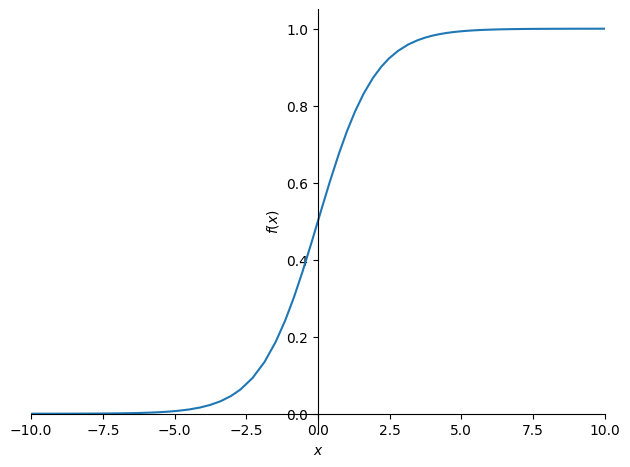

In [40]:
sympy.plot("1/(1+exp(-x))", xlim=(-10,10));

o `PyTorch` j√° possui essa fun√ß√£o, ent√£o podemos modificar a `calc_preds` para inclu√≠-la:

In [41]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

coeffs = train_model(18, lr=0.2)

0.179; 0.155; 0.136; 0.144; 0.163; 0.174; 0.171; 0.153; 0.126; 0.119; 0.148; 0.162; 0.132; 0.098; 0.115; 0.141; 0.145; 0.125; 

A perda diminuiu consideravelmente, agora vejamos a acur√°cia:

In [42]:
acc(coeffs)

tensor(0.9967)

O uso da fun√ß√£o sigmoide acarretou em uma melhora de `1` para `0.9967`.  
A seguir os coeficientes do nosso modelo:

In [43]:
show_coeffs()

{'clonesize': tensor(-0.6389),
 'honeybee': tensor(0.1324),
 'bumbles': tensor(0.3580),
 'andrena': tensor(-0.0381),
 'osmia': tensor(0.0180),
 'MaxOfUpperTRange': tensor(-0.2591),
 'MinOfUpperTRange': tensor(0.5433),
 'AverageOfUpperTRange': tensor(0.3694),
 'MaxOfLowerTRange': tensor(0.3355),
 'MinOfLowerTRange': tensor(-0.3836),
 'AverageOfLowerTRange': tensor(0.2662),
 'RainingDays': tensor(-0.4646),
 'AverageRainingDays': tensor(-0.5272),
 'fruitset': tensor(0.7575),
 'fruitmass': tensor(-0.0184),
 'seeds': tensor(0.4151)}

* ### Conjunto de teste e submiss√£o

Para gerar o arquivo de infer√™ncias e submeter ao kaggle, precisamos ver como o modelo se sai no conjunto de teste:

In [60]:
tst_df = pd.read_csv(path/'test.csv')
tst_df.describe(include=(np.number))

id     clonesize      honeybee       bumbles       andrena         osmia  MaxOfUpperTRange  MinOfUpperTRange  \
count  10194.000000  10194.000000  10194.000000  10194.000000  10194.000000  10194.000000      10194.000000      10194.000000   
mean   20385.500000     19.795958      0.391606      0.286307      0.491328      0.593222         82.207014         49.697204   
std     2942.898656      6.591864      0.390022      0.059867      0.148166      0.139897          9.153442          5.552286   
min    15289.000000     10.000000      0.000000      0.000000      0.000000      0.000000         69.700000         39.000000   
25%    17837.250000     12.500000      0.250000      0.250000      0.380000      0.500000         77.400000         46.800000   
50%    20385.500000     25.000000      0.500000      0.250000      0.500000      0.630000         86.000000         52.000000   
75%    22933.750000     25.000000      0.500000      0.380000      0.630000      0.750000         86.000000         52.000000   
max    25482.000000     37.500000     18.430000      0.585000      0.750000      0.750000         94.600000         57.200000   

       AverageOfUpperTRange  MaxOfLowerTRange  MinOfLowerTRange  AverageOfLowerTRange   RainingDays  AverageRainingDays      fruitset  \
count          10194.000000      10194.000000      10194.000000          10194.000000  10194.000000        10194.000000  10194.000000   
mean              68.687816         59.256465         28.674779             48.592643     18.507360            0.322501      0.501809   
std                7.647629          6.617055          3.198282              5.395790     11.780074            0.165342      0.074707   
min               58.200000         50.200000         24.300000             41.200000      1.000000            0.060000      0.233554   
25%               64.700000         55.800000         27.000000             45.800000     16.000000            0.260000      0.458246   
50%               71.900000         62.000000         30.000000             50.800000     16.000000            0.260000      0.506346   
75%               71.900000         62.000000         30.000000             50.800000     24.000000            0.390000      0.559325   
max               79.000000         68.200000         33.000000             55.900000     34.000000            0.560000      0.652144   

          fruitmass         seeds  
count  10194.000000  10194.000000  
mean       0.446345     36.136349  
std        0.037054      4.019885  
min        0.311921     24.320627  
25%        0.418867     33.231910  
50%        0.446570     36.013557  
75%        0.472670     39.127263  
max        0.535660     46.139425

A seguir fazemos as mesmas adapta√ß√µes da se√ß√£o de limpeza dos dados:

In [62]:
tst_df.fillna(modes, inplace=True)

tst_indep = tensor(tst_df[indep_columns].values, dtype=torch.float)
vals,indices = tst_indep.max(dim=0)
tst_indep = tst_indep / vals

In [55]:
coeffs = train_model(18, lr=0.2)

0.179; 0.155; 0.136; 0.144; 0.163; 0.174; 0.171; 0.153; 0.126; 0.119; 0.148; 0.162; 0.132; 0.098; 0.115; 0.141; 0.145; 0.125; 

In [63]:
preds = (calc_preds(coeffs, tst_indep))
preds

tensor([0.6346, 0.8272, 0.7817, 0.7154, 0.5893, 0.6472, 0.7648,  ..., 0.7918, 0.5658, 0.6606, 0.6985, 0.7372, 0.6365, 0.8254],
       grad_fn=<SigmoidBackward0>)

In [71]:
tst_df['yield'] = preds.detach().numpy()*10000

Guardamos as colunas relevantes em outro dataframe, e exportamos ele para um arquivo `.csv`:

In [72]:
sub_df = tst_df[['id','yield']]
sub_df.to_csv('sub.csv', index=False)

Aqui est√£o as primeiras linhas do arquivo:

In [73]:
!head sub.csv

id,yield
15289,6346.1455
15290,8271.953
15291,7816.574
15292,7153.903
15293,5893.2964
15294,6472.061
15295,7647.849
15296,8099.1934
15297,8345.395


#### Otimiza√ß√µes

Antes de prosseguir para a pr√≥xima parte, podemos fazer algumas otimiza√ß√µes.

O c√≥digo `(indeps*coeffs).sum(axis=1)` nada mais √© do que uma multiplica√ß√£o de matrizes, e essa opera√ß√£o √© suportada pelos tensores do PyTorch e representada pelo python atrav√©s do operador `@`. A sua execu√ß√£o acaba sendo mais eficiente dessa forma, pois produto de matrizes √© uma opera√ß√£o bem otimizada no PyTorch.

In [74]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

Acima atualizamos o `calc_preds` para utilizar a multiplica√ß√£o de matrizes, e o `init_coeffs` para gerar nossos coeficientes em forma de um vetor coluna, ou seja, uma matriz com uma √∫nica coluna, para podermos realizar produtos entre matrizes na pr√≥xima se√ß√£o.

Precisamos tamb√©m transformar as vari√°veis dependentes em um vetor coluna. Isso pode ser feito indexando a coluna com o valor `None`, que diz ao PyTorch para adicionar uma dimens√£o nessa posi√ß√£o:

In [75]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [76]:
coeffs = train_model(lr=0.2)

0.128; 0.125; 0.122; 0.122; 0.122; 0.120; 0.114; 0.109; 0.108; 0.107; 0.101; 0.094; 0.094; 0.094; 0.090; 0.086; 0.088; 0.092; 0.089; 0.086; 0.091; 0.096; 0.095; 0.094; 0.097; 0.102; 0.103; 0.102; 0.101; 0.103; 

In [77]:
acc(coeffs)

tensor(0.8750)

## Rede neural

Podemos enfim implementar uma rede neural.

Primeiramente devem ser criados coeficientes para cada camada. Os primeiros coeficientes v√£o tomar nossa entrada `n_coeff`, e criar um n√∫mero de entradas `n_hidden`. Esse n√∫mero pode ser o que o usu√°rio quiser, sendo que um n√∫mero maior oferece mais flexibilidade, mas torna a rede mais lenta e dif√≠cil de treinar.

Ent√£o teremos uma matriz de dimens√£o `n_coeff` por `n_hidden`. Esses coeficientes ser√£o ent√£o divididos por `n_hidden` para termos n√∫meros com a magnitude similar aos nossos iniciais ap√≥s realizarmos a soma na pr√≥xima camada.

A segunda camada pegar√° as entradas `n_hidden` e retornar√° uma √∫nica sa√≠da, ent√£o precisamos de uma matriz de dimens√£o `n_hidden` por 1. A segunda camada tamb√©m precisa de um termo constante adicionado.

In [78]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Podemos agora criar a rede neural.

Os passos essenciais s√£o os dois produtos de matrizes:
1. `indeps@l1`: vari√°veis independentes * camada 1
2. `res@l2`: resultado da opera√ß√£o acima * camada 2

A sa√≠da da primeira camada √© passada por uma fun√ß√£o retificada linear, e a da segunda √© passada por uma sigmoide.

Por fim, criamos um loop para atualizar cada conjunto de coeficientes:

In [79]:
def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Podemos agora treinar o modelo.

In [80]:
coeffs = train_model(lr=0.2)

0.173; 0.144; 0.125; 0.121; 0.119; 0.119; 0.118; 0.117; 0.117; 0.116; 0.115; 0.115; 0.114; 0.114; 0.113; 0.113; 0.112; 0.112; 0.111; 0.111; 0.110; 0.110; 0.109; 0.109; 0.108; 0.108; 0.107; 0.107; 0.106; 0.106; 

Nota-se uma melhora na perda. Vejamos a acur√°cia:

In [81]:
acc(coeffs)

tensor(1.)

Em termos de acur√°cia a performance da rede neural em contraste com o modelo linear n√£o melhorou. Isso √© de se esperar, visto que nosso dataset √© simples e nosso conjunto de valida√ß√£o √© pequeno.

### Conclus√£o

N√£o √© um procedimento muito pr√°tico e tamb√©m nem muito simples, mas √© muito gratificante construir uma rede neural do nada, especialmente ap√≥s ter feito algumas com a ajuda de uma biblioteca como o fastai.

O que mais me chamou aten√ß√£o nessa aula foi a parte de limpeza dos dados, principalmente as maneiras criativas de se tornar valores inutiliz√°veis em algo que nosso modelo possa processar.

## Infer√™ncia

Aqui est√° o link para o [huggingface.co](https://huggingface.co/spaces/Herises/FastaionCampus)

> ps. Professor, por favor, se o huggingface app n√£o funcionar pelo menos me de uma nota minima, agrade√ßo üôè